$\textbf{GOAL :}$ We want to see if we can find better local minima by using **Moreau envelop**.
We focus on the loss function $\sqrt{RSS}$ and $P_\nu$ as penalty non convex. 

# Theory

## Recall

For $F : \mathbb{R}^p \to \mathbb{R} \cup \{+\infty\}$ and $\gamma > 0$,  
$$
\operatorname{prox}_{\gamma, F}(x) \;=\;
\arg\min_{z} \; F(z) + \frac{1}{2\gamma} \| z - x \|_2^2
$$


## Moreau's envelop

Moreau's envelop for $F$ is denoted $F_\mu$. For $\mu>0$

$$
F_\mu(x) := \min_{z} \; F(z) + \frac{1}{2\mu} \| z - x \|_2^2
$$

$F_\mu$ is smoother than $F$ and has same stationnary point than $F$ <span style="color:red"><b>Vrai sous certaines conditions que ne nous vérifions pas ! Je pense qu'on a que le minimum global qui coincide à coup sûr</b></span> and is below $F$.

We want minimize
$$
F : \beta \mapsto \|y - X\beta\|_2 + \lambda P_\nu(\beta)
$$

with (recall from `l_qut_2`) $P_\nu(\beta) = \sum_{j=1}^p \rho_\nu(|\beta_j|)$ where $\rho_\nu$ is continuous, différentiable except in 0, coercive, folded concave and $\lambda > 0$. We keep $0 < \nu < 1.$  

Until now, we express the proximal of $\lambda P_\nu$ to minimize F by ISTA where $f(\beta) = \|y - X\beta\|_2$ is the smooth part.

$$
x_{k+1} = \operatorname{prox}_{\gamma, \lambda P_\nu}(x_k - \gamma \partial f(x_k) )
$$

We now want to apply the same idea to $F_\mu$.

From the definition of the gradient of the envelope <span style="color:red"><b>Find source about the expression of grad envelop = x-prox(x)</b></span> a gradient step on $F_\mu$ with step size $\mu$ is

$$
x_{k+1} = x_k - \mu\, \partial F_\mu(x_k) = \operatorname{prox}_{\mu, F}(x_k)
$$

This is our outer loop update.


The proximal map $\operatorname{prox}_{\mu, F}(x_k)$ has no closed form here, because $F = f+g$ with
$f(\beta) = \|y - X\beta\|_2$ and $g(\beta) = \lambda P_\nu(\beta)$.

We therefore introduce, for a fixed outer center $\beta^k$, the function

$$
h(u) := \|y - Xu\|_2 + \frac{1}{2\mu}\|u - \beta^k\|_2^2
$$

and note that

$$
\operatorname{prox}_{\mu, F}(\beta^k) = \arg\min_u \; h(u) + \lambda P_\nu(u)
$$

The subgradient of $h$ with respect to $u$ is

$$
\partial_u h(u) = -\frac{X^\top r(u)}{\|r(u)\|_2} + \frac{1}{\mu}(u - \beta^k),
\quad r(u) := y - X u
$$

We then compute $\operatorname{prox}_{\mu, F}(\beta^k)$ by **ISTA on the inner problem**:

$$
u_{t+1} = \operatorname{prox}_{\gamma, \lambda P_\nu}\big(u_t - \gamma\, \partial h(u_t) \big)
$$

with $\gamma$ satisfying the usual step-size condition for the inner smooth part.

At the start of the inner loop, we set $u_0 = x_k$, and as $t \to \infty$ we have $u_t \to x_{k+1}$, the next outer iterate.


Due to the behaviour of $P_\nu$ near of $0$, we aren't $\mu$-weakly convex for finit $\mu$ but we will still going use it.


<!-- We take,
$$
\mu
  \;=\;
  c\cdot\frac{\|y-X\beta^0\|_2}{\|X\|_2^2}
  \quad\text{with } c\in[1,10].
  $$ -->

# Experiments

In [1]:
using LinearAlgebra, Statistics, Random, Printf, Plots

In [2]:
include("../functions/ISTA.jl")
include("../functions/metrics.jl")

import .ISTA: ista_L, ista
import .metrics: pesr, tpr, fdr, f1score

In [3]:
rho(x, ν)  = abs(x) / (1 + abs(x)^(1-ν))
rho_prime(x, ν) = (1 + ν*abs(x)^(1-ν)) / (1 + abs(x)^(1-ν))^2 

rho_prime (generic function with 1 method)

In [ ]:
function bisection(f, a, b; tol=1e-10, maxiter=1000, verbose=false)
    if f(a)==0
        return a, 0
    end
    if f(b)==0
        return b, 0
    end
    
    if verbose
        @printf("start with a = %.12f : f(a) = %.12f, b = %.12f : f(b) = %.12f\n", a, f(a), b, f(b))
    end
    fa, fb = f(a), f(b)
    # TODO : attention ! special pour ce cas et se rappeler pourquoi
    while f(a)*f(b)>0
        b*=2
        if b> 1e10
            return a, -1
        end
        
    end
    # @assert fa * fb < 0 "Need f(a)f(b)<0 : $(fa) | $(fb)"
    for k in 1:maxiter
        m  = 0.5*(a+b)
        fm = f(m)
        if abs(fm) <= tol || 0.5*(b-a) <= tol
            if verbose
                @printf("bisection: found %.12f in %d iterations | a = %.12f, b = %.12f, f(a) = %.12f, f(b) = %.12f\n", m, k, a, b, fa, fb)
            end         
            return m, k
        elseif fm>0
            b, fb = m, fm
        else
            a, fa = m, fm
        end
    end
    error("No convergence in $maxiter iterations")
end

bisection (generic function with 1 method)

In [5]:
function kappa_phi(Γ::Float64, ν::Float64)
    T = eps(Float64)
    kappa_poly(κ) = κ^(2-ν) + 2κ + κ^ν + 2Γ*(ν-1) 
    κ, it = bisection(kappa_poly, 0.0, max(1.0, Γ*(1-ν)), verbose=false)
    φ = κ/2 +  Γ/(1 + κ^(1-ν))

    return κ, φ
end

kappa_phi (generic function with 1 method)

In [6]:
function x_tar(z::Float64, Γ::Float64, ν::Float64, κ::Float64)
    h(x) = x + Γ * rho_prime(x, ν) - z
    res, _ = bisection(h,κ,z; tol = 1e-10, verbose=false)
    return res
end

x_tar (generic function with 1 method)

In [7]:
function prox_harder_vec(z::AbstractVector, γ::Float64, λ::Float64, ν::Float64)
    if ν== 1.0 
        return sign.(z) .* max.(abs.(z) .- γ * λ*0.5, 0.0) # soft thresholding (see l_qut_1) # TODO page 4 harderLASSO pdf phi_1 (confirmer)
    end
    # else proximal operator for harder penalty
    Γ = γ * λ 
    κ, φ = kappa_phi(Γ, ν)    

    β_new = map(z[1:end-1]) do zi # coordinate loop
        abs(zi) ≤ φ - eps() ? 0.0 : sign(zi) * x_tar(abs(zi), Γ, ν, κ) 
    end
    return vcat(β_new, z[end])
end


prox_harder_vec (generic function with 1 method)

In [8]:
function lambda_local0(y, X; verbose=false)
    r = y .- mean(y)
    if verbose
        @printf("residu norm : %.12f\n", norm(r))
    end
    return maximum(abs.(X' * r)) / norm(r)
end

function lambda_qut_v(X; α=0.05, M=1000, rng=Random.GLOBAL_RNG, verbose=false)
    n = size(X,1)
    λvals = Vector{Float64}(undef, M)
    for m in 1:M
        y0 = randn(rng, n)
        λvals[m] = lambda_local0(y0, X; verbose=verbose)
    end
    return quantile!(λvals, 1-α)
end

lambda_qut_v (generic function with 1 method)

In [88]:
function phase_transition_nu(n, p, s_list, ν; σ=0.1, B=20, α=0.05, tol=1e-9, seed=42)
    m = length(s_list)
    pesr_rate = zeros(m)
    f1_rate = zeros(m)
    fdr_rate = zeros(m)
    tpr_rate = zeros(m)

    Random.seed!(42)

    for (i, s) in enumerate(s_list)
        acc_pesr = acc_f1 = acc_fdr = acc_tpr = 0.0

        for _ in 1:B
            X = randn(n, p)
            X .-= mean(X; dims=1)
            X ./= std(X;  dims=1)

            β = zeros(p)
            β[randperm(p)[1:s]] .= 3
            β_hat = run_trial_nu(X, β, σ, ν; α=α, tol=tol, c_intercept=4)

            y, ŷ = abs.(β) .> 0, abs.(β_hat) .> 0

            acc_pesr += pesr(β, β_hat; tol=0)
            acc_f1 += f1score(y, ŷ)
            acc_fdr += fdr(y, ŷ)
            acc_tpr += tpr(y, ŷ)
        end

        pesr_rate[i] = acc_pesr/B
        f1_rate[i] = acc_f1 /B
        fdr_rate[i] = acc_fdr/B
        tpr_rate[i] = acc_tpr/B
    end

    return s_list, pesr_rate, f1_rate, fdr_rate, tpr_rate
end

phase_transition_nu (generic function with 1 method)

## Envelop

In [89]:
function run_trial_nu(X, β, σ, ν; α=0.05, tol=1e-9, max_iter=10_000, mu=1., mu0=15, c_intercept=0.0)
    n = size(X, 1)
    X̃ = hcat(X, ones(n)) # Ajout colonne d'intercept
    y = X * β .+ σ * mu *randn(n) .+ c_intercept
    
    λ_QUT = lambda_qut_v(X; α = α, M = 1000, verbose = false)

    θ  = zeros(p + 1) 
    r0 = y - X̃*θ
    L2 = opnorm(X̃)
    mu_env = mu0

    θ_center = copy(θ)

    f(θu) = norm(y - X̃*θu, 2) + (1/(2*mu_env))*norm(θu - θ_center, 2)^2

    function ∇f(θu)
        r = y - X̃*θu
        nr = norm(r)
        # sous-gradient "safe" si nr ~ 0
        g_loss = (nr > 0) ? (-X̃' * (r / nr)) : zero(θu)
        g_ridge = (θu - θ_center) / mu_env
        return g_loss + g_ridge
    end

    
    
    g(θu)      = λ_QUT * sum(rho.(θu[1:end-1], ν))
    prox( z,γ ) = prox_harder_vec(z, γ, λ_QUT, ν)
    
    beta_mu   = 2.      # facteur de réduction de μ (0<beta_mu<1)
    sigma_suf = 1e-4     # constante de décroissance suffisante
    max_bt    = 10       # tentatives maxi de backtracking sur μ
    L0        = 1e-4    # L initial pour ISTA interne (tu peux backtracker dedans indépendamment)
    
    # θ = ista(θ, f, g, ∇f, L0, prox;max_iter = 10_000,tol= tol,verbose  = false)
    K_ext = 0
    while true
        θ_center .= θ  # centre du sous-problème (extérieur)

        # valeur de référence de l’objectif interne au centre (terme ridge = 0)
        m_center() = norm(y - X̃*θ_center, 2) + g(θ_center)

        accepted = false
        θ_try = copy(θ_center)

        # Backtracking sur mu_env : tant que l’on n’a pas la décroissance voulue
        for bt in 1:max_bt
            # IMPORTANT: f, ∇f utilisent mu_env et θ_center par fermeture -> OK après mise à jour de mu_env
            # On résout le sous-problème fortement convexe avec ISTA (inner loop)
            u0 = θ_center
            θ_try = ista(u0, f, g, ∇f, L0, prox; max_iter=max_iter, tol=tol, verbose=false)

            Δ = norm(θ_try - θ_center)
            m_new = f(θ_try) + g(θ_try)       # = m_mu(θ_try ; θ_center)
            m_old = m_center()                # = f(θ_center)+g(θ_center)

            # Critère d'acceptation (décroissance suffisante)
            if m_new <= m_old - (sigma_suf/(2*mu_env))*Δ^2
                accepted = true
                break
            else
                # Réduire μ -> renforce la convexité forte via 1/(2μ)||u-θ_center||^2
                mu_env *= beta_mu
                # pas besoin de recréer f/∇f: ils lisent mu_env/θ_center actuels
            end
        end

        # Si jamais pas accepté après max_bt, on prend la dernière tentative
        θ .= θ_try

        # critère d’arrêt externe: ||θ^{k+1} - θ^k|| / μ_env
        if norm(θ - θ_center) / mu_env <= 1e-8
            break
        end

        K_ext += 1
        if K_ext > 100
            println("K_ext exceeded 100 iterations, stopping early")
            break
        end
    end

    return θ[1:p]
end


run_trial_nu (generic function with 1 method)

In [90]:
n, p = 70, 250
s_lst = 0:22
B_trial = 8
sigma = 0.1
ν = 0.1

s, pesr_r, f1_r, fdr_r, tpr_r = phase_transition_nu(n, p, s_lst, ν; σ=sigma, B=B_trial, tol=1e-9)

(0:22, [1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 0.875, 0.875  …  0.625, 0.625, 0.125, 0.25, 0.125, 0.125, 0.125, 0.0, 0.0, 0.0], [0.0, 1.0, 1.0, 0.9821428571428571, 1.0, 1.0, 1.0, 1.0, 0.9926470588235294, 0.993421052631579  …  0.7983954451345756, 0.8436231884057972, 0.6236706829333871, 0.6497644478009135, 0.5393718055090594, 0.6711036177161733, 0.5201615524707358, 0.40155333577712615, 0.5264828866222055, 0.423322691398331], [0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.013888888888888888, 0.0125  …  0.15625, 0.11161616161616161, 0.23621031746031748, 0.24069264069264068, 0.36857413419913415, 0.191570439364557, 0.3351731601731602, 0.4565122377622378, 0.330971571320836, 0.34322621822621824], [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.7692307692307693, 0.8125, 0.55, 0.5859375, 0.4852941176470589, 0.5972222222222221, 0.4473684210526316, 0.31875000000000003, 0.44642857142857134, 0.32386363636363635])

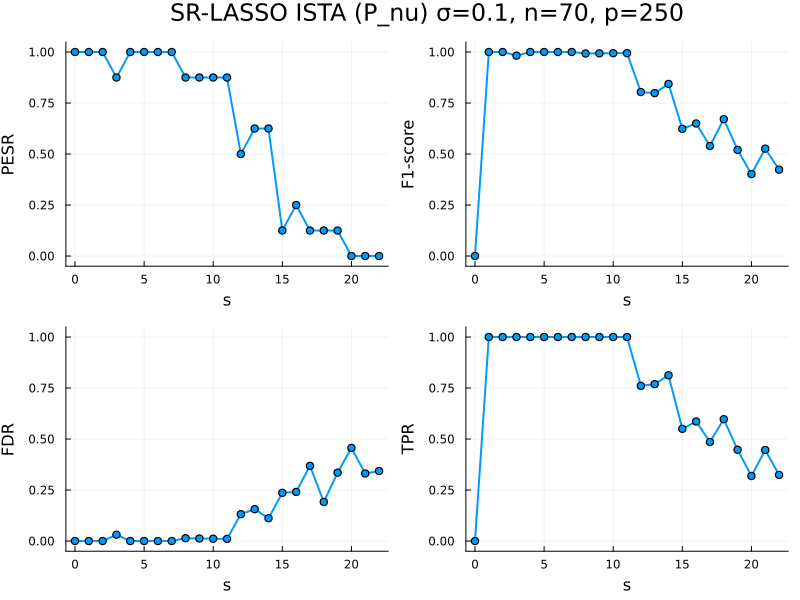

In [91]:
main_title = "SR-LASSO ISTA (P_nu) σ=$sigma, n=$n, p=$p"
plot(
    plot(s, pesr_r; xlabel="s", ylabel="PESR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, f1_r; xlabel="s", ylabel="F1-score", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, fdr_r; xlabel="s", ylabel="FDR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, tpr_r; xlabel="s", ylabel="TPR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    layout =(2, 2), size = (800, 600), plot_title=main_title
)

# Visualization

In [3]:
using LinearAlgebra, Plots, Printf, LaTeXStrings

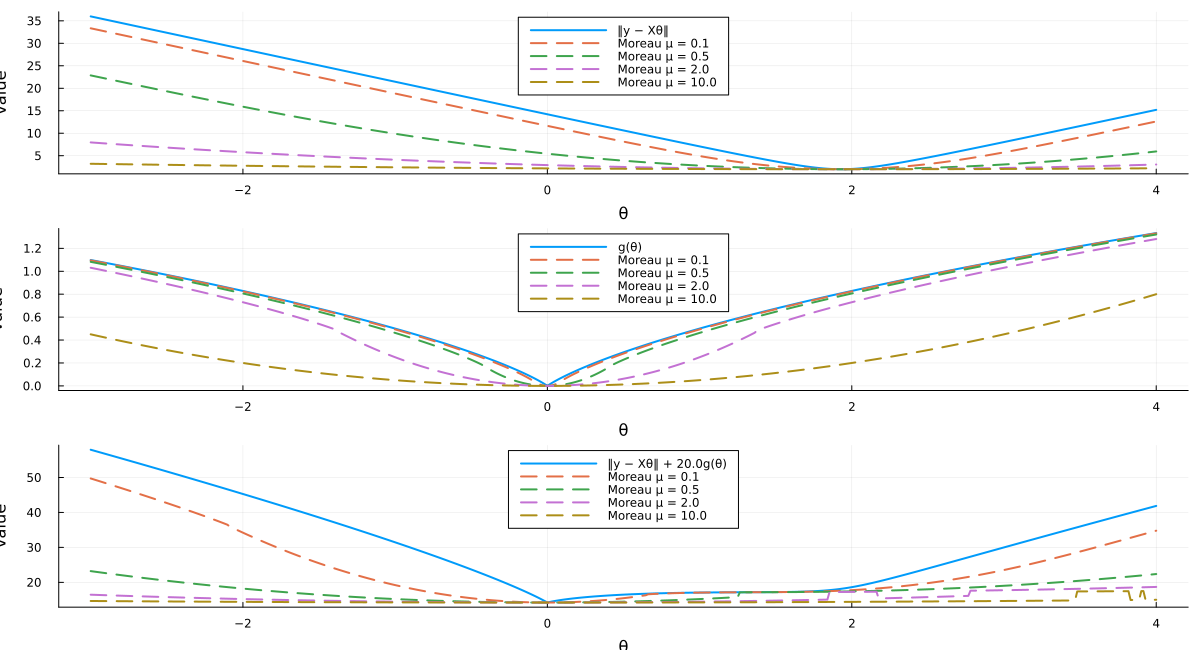

In [18]:
###############################################################################
# Three losses vs their Moreau envelopes (p = 1)                              #
#   • loss1 = ‖y − Xθ‖
#   • loss2 = g(θ) = |θ| / (1 + |θ|^0.5)
#   • loss3 = loss1 + λ * loss2  with λ = 2
# Smoothing parameter μ ∈ {0.1, 0.5, 2.0, 10.0}                               #
# Requires:  Pkg.add.(["Plots","LinearAlgebra","Optim"])                       #
###############################################################################
using LinearAlgebra, Plots, Optim, Random

# 1 ─── synthetic data (used only for loss1) ----------------------------------
rng       = MersenneTwister(2025)
n         = 50
x         = randn(rng, n)
θ_true    = 2.0
noise_sd  = 0.3
y         = x .* θ_true .+ noise_sd * randn(rng, n)

# 2 ─── loss functions --------------------------------------------------------
ϕ₁(u) = norm(y .- x .* u)                        # ‖y − Xθ‖
ϕ₂(u) = abs(u) / (1 + abs(u)^0.5)                # g(θ)
λ      = 20.0                                     # fixed coefficient
ϕ₃(u) = ϕ₁(u) + λ * ϕ₂(u)                        # composite

# 3 ─── Moreau envelope helper (Brent, 1-D) -----------------------------------
function moreau_envelope(ϕ, θ, μ; h = 10.0)
    obj(u) = ϕ(u) + (0.5/μ) * (u - θ)^2
    res    = optimize(obj, θ - h, θ + h, Brent())
    return Optim.minimum(res)
end

# 4 ─── θ-grid and envelope families -----------------------------------------
θ_grid = range(-3, 4; length = 500)
μs     = [0.1, 0.5, 2.0, 10.0]

loss₁  = [ϕ₁(θ) for θ in θ_grid]
loss₂  = [ϕ₂(θ) for θ in θ_grid]
loss₃  = [ϕ₃(θ) for θ in θ_grid]

envs(ϕ) = [ [moreau_envelope(ϕ, θ, μ) for θ in θ_grid] for μ in μs ]
env₁, env₂, env₃ = envs(ϕ₁), envs(ϕ₂), envs(ϕ₃)

# 5 ─── plotting --------------------------------------------------------------
plt = plot(layout = (3,1), legend = :top, xlabel = "θ", ylabel = "value", size = (1200, 650))

# (i) residual norm
plot!(plt[1], θ_grid, loss₁; label = "‖y − Xθ‖", linewidth = 2)
for (i, μ) in pairs(μs)
    plot!(plt[1], θ_grid, env₁[i]; label = "Moreau μ = $(μ)", linewidth = 2, linestyle = :dash)
end

# (ii) custom penalty
plot!(plt[2], θ_grid, loss₂; label = "g(θ)", linewidth = 2)
for (i, μ) in pairs(μs)
    plot!(plt[2], θ_grid, env₂[i]; label = "Moreau μ = $(μ)", linewidth = 2, linestyle = :dash)
end

# (iii) composite loss
plot!(plt[3], θ_grid, loss₃; label = "‖y − Xθ‖ + $(λ)g(θ)", linewidth = 2)
for (i, μ) in pairs(μs)
    plot!(plt[3], θ_grid, env₃[i]; label = "Moreau μ = $(μ)", linewidth = 2, linestyle = :dash)
end

display(plt)
